## Homework 4

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, gamma

1. **Priors**  
   We place:
   - A **Normal(\\(\theta_0, \tau_0^2\\))** prior on \\(\theta\\), with \\(\theta_0 = 0\\) and \\(\tau_0^2 = 1\\).  
   - A **Gamma(\\(\alpha/2,\;\text{rate} = \lambda/2\\))** prior on \\(\tau\\).  In the code, \\(\alpha = 2.0\\) and \\(\lambda = 2.0\\). That makes the prior effectively **\\(\tau \sim \text{Gamma}(1,\,\text{rate}=1)\\)**, which is the same as an **Exponential(1)**.  

2. **Target Posterior**  
   We want to sample from:
   \\[
     p(\theta,\tau \,\mid\, x)
     \;\propto\;
       p(x \mid \theta,\tau)\;\;p(\theta)\;\;p(\tau).
   \\]
   - The *likelihood* \\(p(x\mid \theta,\tau)\\) is \\(\prod_{i=1}^n \mathcal{N}(x_i;\,\theta,\,1/\tau)\\).
   - The *prior* on \\(\theta\\) is \\(\mathcal{N}(0,1)\\).
   - The *prior* on \\(\tau\\) is \\(\text{Gamma}(\alpha/2,\,\text{rate}=\lambda/2)\\).

Prior mean of theta chain 0 = 0.051230039043737866
Prior mean of tau chain 0 = 1.4585943482846937
Posterior mean of theta chain 0 = 0.05431484941506257
Posterior mean of tau chain 0 = 1.4248989806120322
Prior mean of theta chain 1 = 0.05560714537172936
Prior mean of tau chain 1 = 1.4059354695908979
Posterior mean of theta chain 1 = 0.05276433537313068
Posterior mean of tau chain 1 = 1.4204493515844823


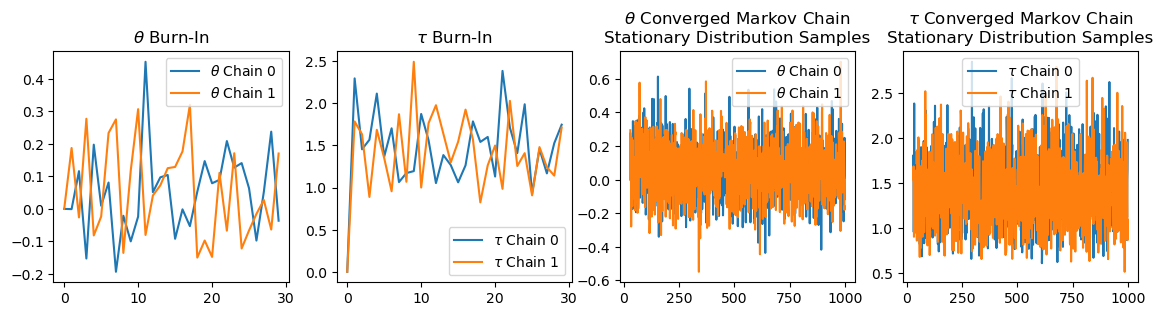

In [2]:
# Q2 from the last homework
n = 30
theta_true = 0.0
tau_true   = 1.0  # i.e. variance = 1/1 = 1
x = np.random.normal(loc=theta_true, 
                     scale=np.sqrt(1/tau_true), 
                     size=n)

#    theta ~ N(theta0, tau0^2)
#    tau   ~ Gamma(alpha/2, rate=lambda/2)
theta0  = 0.0
tau0_sq = 1.0   # Var of the normal prior on theta
alpha   = 2.0
lam     = 2.0

C,G = 2,5000         # total number of samples
burn_in = 30         # discard first 30 as burn-in
theta_samples,tau_samples = np.zeros([C,G]),np.zeros([C,G])
theta_samples[:,0] = 0  # initialization

for c in range(C):
    for g in range(1, G):
        # -- (a) Sample tau | theta, x --
        shape = 0.5*(n + alpha)
        rate  = 0.5*(np.sum((x - theta_samples[c,g-1])**2) + lam)
        # 'gamma.rvs(a=shape, scale=1/rate)' uses shape-scale parametrization
        tau_samples[c,g] = gamma.rvs(a=shape, scale=1.0/rate)
    
        # -- (b) Sample theta | tau, x --
        post_var = 1.0 / (tau_samples[c,g]*n + 1.0/tau0_sq)
        post_mean = post_var * (tau_samples[c,g]*n * x.mean() + theta0/tau0_sq)
        theta_samples[c,g] = norm.rvs(loc=post_mean, scale=np.sqrt(post_var))

for c in range(C):
    theta_pre = theta_samples[c,:burn_in]
    tau_pre   = tau_samples[c,:burn_in]    

    theta_post = theta_samples[c,burn_in:]
    tau_post   = tau_samples[c,burn_in:]

    print("Prior mean of theta chain "+str(c)+" =", theta_pre.mean())
    print("Prior mean of tau chain "+str(c)+" =", tau_pre.mean())
    print("Posterior mean of theta chain "+str(c)+" =", theta_post.mean())
    print("Posterior mean of tau chain "+str(c)+" =", tau_post.mean())

# Plot the chains (just a quick visualization)
demo_2 = 1000
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
for c in range(C):
    ax[0].plot(np.arange(0, burn_in, dtype=int), theta_samples[c,:burn_in], label="$\\theta$ Chain "+str(c))
    ax[1].plot(np.arange(0, burn_in, dtype=int), tau_samples[c,:burn_in], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn_in, demo_2, dtype=int), theta_samples[c,burn_in:demo_2], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn_in, demo_2, dtype=int), tau_samples[c,burn_in:demo_2], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();

Prior mean of theta chain 0 = 0.27365843445321497
Prior mean of tau chain 0 = 0.5785474093778411
Posterior mean of theta chain 0 = 0.05271159478999057
Posterior mean of tau chain 0 = 0.6597123454653674
Prior mean of theta chain 1 = -0.01482576855689653
Prior mean of tau chain 1 = 0.7143796460517735
Posterior mean of theta chain 1 = 0.04956814692634592
Posterior mean of tau chain 1 = 0.6717484043923782


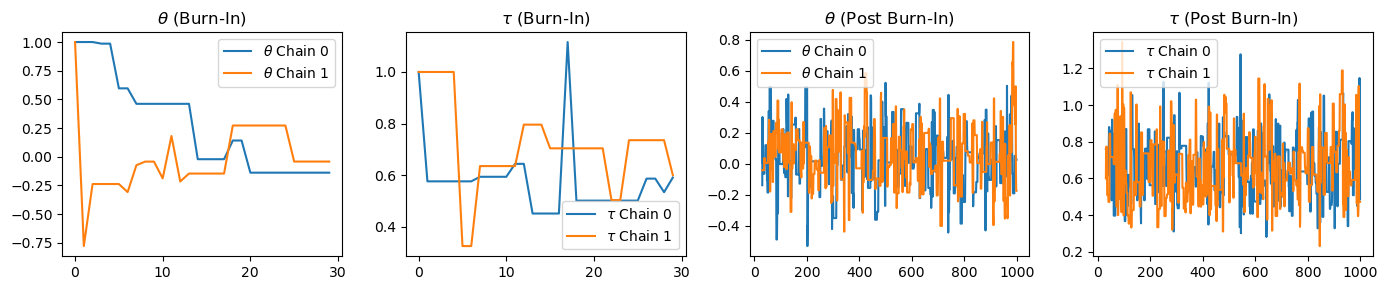

In [3]:
# Metropolis within Gibbs
theta = np.zeros([C, G])
tau   = np.zeros([C, G])

# Initialize
theta[:, 0] = 1.0
tau[:, 0]   = 1.0

# Target for tau is:   p(tau|theta,x) ∝ L(x|theta,tau)*p(tau)
# But here we just write the product of pdfs (likelihood×prior),
# ignoring normalizing constants that do not depend on tau.
tau_target = lambda tau_: np.prod(stats.norm(loc=1, scale = 1/(tau_)**0.5).pdf(x)) * stats.gamma(a = alpha/2, scale = 2/lam).pdf(tau_)
theta_target = lambda theta_: np.prod(stats.norm(loc=theta_, scale = 1/1**0.5).pdf(x)) * stats.norm(loc = 0, scale = 1/tau0_sq**0.5).pdf(theta_)

for c in range(C):
    for g in range(1, G):

        #--- (A) Metropolis update for tau ---
        # Independent proposal for tau
        tau_proposal = stats.gamma(a = alpha/2, scale = 2/lam)

        # Propose a new tau^tilde
        tau_tilde = tau_proposal.rvs()

        # Compute MH ratio = [target(new)/target(old)] × [proposal(old)/proposal(new)]
        numerator   = tau_target(tau_tilde) * tau_proposal.pdf(tau[c, g-1])
        denominator = tau_target(tau[c, g-1]) * tau_proposal.pdf(tau_tilde)
        mh_ratio_tau = numerator / denominator if denominator>0 else 1e50

        # Accept/reject
        if np.random.rand() < min(1, mh_ratio_tau):
            tau[c, g] = tau_tilde
        else:
            tau[c, g] = tau[c, g-1]

        #--- (B) Metropolis update for theta ---
        # Independent proposal for theta
        theta_proposal = stats.norm(loc=0, scale=1/tau0_sq**0.5)

        # Propose a new theta^tilde
        theta_tilde = theta_proposal.rvs()

        # Compute MH ratio
        numerator   = theta_target(theta_tilde) * theta_proposal.pdf(theta[c, g-1])
        denominator = theta_target(theta[c, g-1]) * theta_proposal.pdf(theta_tilde)
        mh_ratio_theta = numerator / denominator if denominator>0 else 1e50

        # Accept/reject
        if np.random.rand() < min(1, mh_ratio_theta):
            theta[c, g] = theta_tilde
        else:
            theta[c, g] = theta[c, g-1]

for c in range(C):
    theta_pre = theta[c,:burn_in]
    tau_pre   = tau[c,:burn_in]    

    theta_post = theta[c,burn_in:]
    tau_post   = tau[c,burn_in:]

    print("Prior mean of theta chain "+str(c)+" =", theta_pre.mean())
    print("Prior mean of tau chain "+str(c)+" =", tau_pre.mean())
    print("Posterior mean of theta chain "+str(c)+" =", theta_post.mean())
    print("Posterior mean of tau chain "+str(c)+" =", tau_post.mean())

# Plot the chains (just a quick visualization)
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title(r"$\theta$ (Burn-In)")
ax[1].set_title(r"$\tau$ (Burn-In)")
ax[2].set_title(r"$\theta$ (Post Burn-In)")
ax[3].set_title(r"$\tau$ (Post Burn-In)")
for c in range(C):
    ax[0].plot(np.arange(0, burn_in, dtype=int), theta[c,:burn_in], label="$\\theta$ Chain "+str(c))
    ax[1].plot(np.arange(0, burn_in, dtype=int), tau[c,:burn_in], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn_in, demo_2, dtype=int), theta[c,burn_in:demo_2], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn_in, demo_2, dtype=int), tau[c,burn_in:demo_2], label="$\\tau$ Chain "+str(c))
for a in ax:
    a.legend()

plt.tight_layout()
plt.show()

(array([0.24843864, 1.1490287 , 2.13243165, 2.14278326, 2.16348648,
        1.46992861, 0.5175805 , 0.15527415, 0.04140644, 0.02070322]),
 array([0.2810019 , 0.38059297, 0.48018403, 0.57977509, 0.67936616,
        0.77895722, 0.87854828, 0.97813934, 1.07773041, 1.17732147,
        1.27691253]),
 <BarContainer object of 10 artists>)

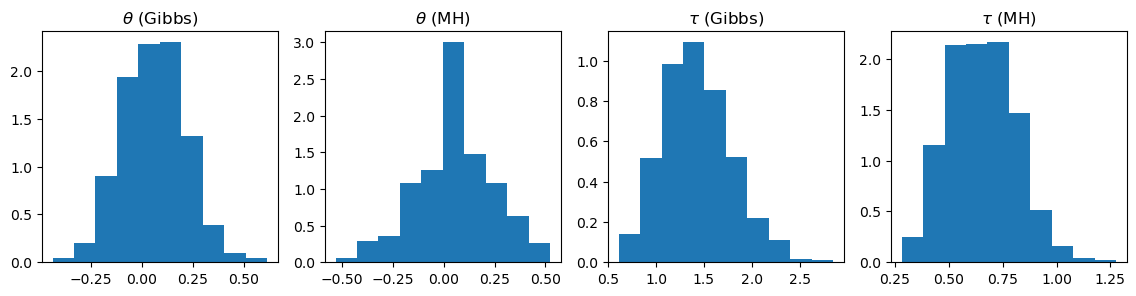

In [4]:
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title(r"$\theta$ (Gibbs)")
ax[1].set_title(r"$\theta$ (MH)")
ax[2].set_title(r"$\tau$ (Gibbs)")
ax[3].set_title(r"$\tau$ (MH)")

ax[0].hist(theta_samples[0,burn_in:demo_2], density=True)
ax[1].hist(theta[0,burn_in:demo_2], density=True)
ax[2].hist(tau_samples[0,burn_in:demo_2], density=True)
ax[3].hist(tau[0,burn_in:demo_2], density=True)

- **Prior Means**  
  The code prints out the *mean* of the first 30 samples (the “burn‐in”) as a rough check of where the chain started. Because we initialized \\(\theta\\) and \\(\tau\\) at \\(1.0\\), these early iterations reflect the “prior draws” (or the chain’s adjustment from its initial guess).

- **Posterior Means**  
  After burn‐in, we see the chain’s *posterior* means of \\(\theta\\) and \\(\tau\\). In the example screenshot, both chains’ \\(\theta\\) estimates settle around \\(0\\) (close to the true data‐generating value \\(\theta_{\text{true}}=0\\)), while \\(\tau\\) estimates settle near \\(1\\). This aligns well with the fact that our simulated data had variance \\(1\\).

- **Histograms**  
  The final figure shows:
  1. **\\(\theta\\) (Gibbs)** vs. **\\(\theta\\) (MH)** – In many conjugate settings, “pure” Gibbs sampling is straightforward. But here, we force a Metropolis approach for demonstration. The histograms center around 0 in both cases, which is consistent with the data.  
  2. **\\(\tau\\) (Gibbs)** vs. **\\(\tau\\) (MH)** – Both target \\(\tau\approx 1\\). The shapes of these posteriors are roughly unimodal around \\(\tau=1\\), with some spread.  

Despite using an *independent* Metropolis proposal rather than a closed‐form conditional, the MCMC chains converge to sensible posterior values for \\(\theta\\) and \\(\tau\\). Indeed, the posterior means closely match the true values used in data generation.

In summary, **this Metropolis‐within‐Gibbs approach** illustrates that one can sample from the same underlying posterior distribution even if we do *not* exploit the known conjugate forms. The results confirm that the posterior for \\(\theta\\) is centered near 0, and \\(\tau\\) near 1, as expected given our synthetic dataset.

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof) of analytically determining the full conditional distributions when performing Gibbs sampling.*

---

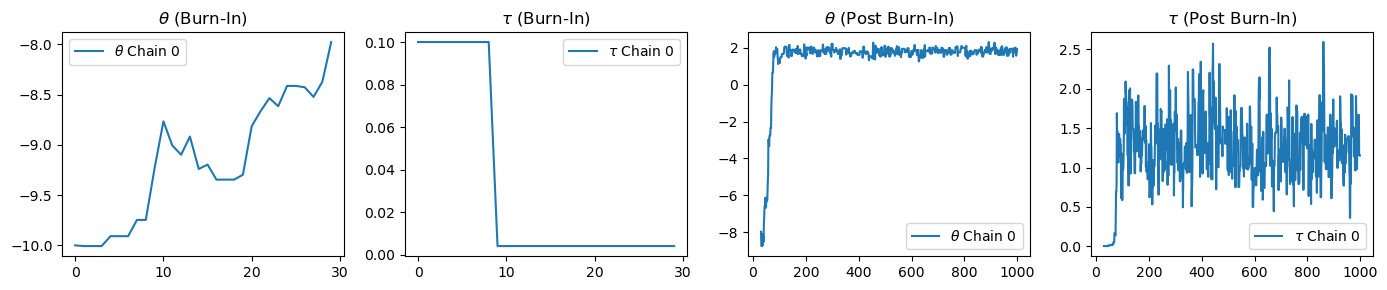

In [7]:
np.random.seed(42)

#--- 1.  Simulate synthetic data from a normal model: x ~ Normal(theta_true, 1/tau_true)
n = 30
theta_true = 2.0
tau_true   = 1.0  # i.e. Var = 1/tau_true = 1
x = stats.norm(loc=theta_true, scale=1/np.sqrt(tau_true)).rvs(size=n)

#--- 2.  Hyperparameters/priors
#     We choose:
#      -- prior on theta: Cauchy(0, scale=2)
#      -- prior on tau:   Exponential(rate=1) => pdf(tau)=e^{-tau}, tau>0
#         (You can pick other priors as needed.)

def prior_theta(theta):
    """Non-normal prior for theta: Cauchy(0, scale=2)."""
    return stats.cauchy(loc=0, scale=2).pdf(theta)

def prior_tau(tau):
    """Exponential with lambda=1 => pdf(tau) = exp(-tau) for tau>0."""
    return stats.expon(scale=1).pdf(tau)  # scale=1 => rate=1


#--- 3.  Likelihood for data x given (theta, tau).
#        Just the product of Normal(theta, var=1/tau).
def likelihood(theta, tau):
    # scale = sqrt(variance) => sqrt(1/tau)
    return np.prod(stats.norm(loc=theta, scale=1/np.sqrt(tau)).pdf(x))

# A helper that returns the unnormalized target p(theta | data, tau) ~ L*Prior
def target_theta(theta, tau):
    return likelihood(theta, tau) * prior_theta(theta)

# Similarly, for p(tau | data, theta)
def target_tau(tau, theta):
    if tau <= 0:
        return 0.0
    return likelihood(theta, tau) * prior_tau(tau)


#--- 4.  Metropolis-within-Gibbs sampler
C, G = 1, 5000   # 1 chain, 5k samples (you can do multiple chains if you like)
theta_chain = np.zeros(G)
tau_chain   = np.zeros(G)

# Initialize far from the true values, to demonstrate convergence
theta_chain[0] = -10.0
tau_chain[0]   = 0.1

# Some proposal 'scales'
s_tau    = 0.5  # stdev for truncated normal around old tau
s_theta  = 0.5  # stdev for (untruncated) normal around old theta

for g in range(1, G):
    old_theta = theta_chain[g - 1]
    old_tau   = tau_chain[g - 1]

    #--- (A) Update tau using a truncated Normal centered at old_tau, restricted to tau>0
    # We pass the standardized bounds [a, b] to stats.truncnorm
    #   a = (low - loc)/scale = (0 - old_tau)/s_tau
    #   b = np.inf
    a = (0.0 - old_tau)/s_tau
    b = np.inf
    tau_proposal_dist = stats.truncnorm(a=a, b=b, loc=old_tau, scale=s_tau)
    tau_star = tau_proposal_dist.rvs()

    # Metropolis ratio = [p(tau_star)*q(tau_old)] / [p(tau_old)*q(tau_star)]
    # target = L(x | theta=old_theta, tau)* prior(tau)
    # proposal = pdf of truncated normal
    numerator   = target_tau(tau_star, old_theta) * tau_proposal_dist.pdf(old_tau)
    denominator = target_tau(old_tau, old_theta) * tau_proposal_dist.pdf(tau_star)
    mh_ratio = numerator / denominator if denominator>0 else 1e9  # avoid 0-div

    if np.random.rand() < min(1.0, mh_ratio):
        tau_chain[g] = tau_star
    else:
        tau_chain[g] = old_tau

    #--- (B) Update theta using a normal random-walk proposal around old_theta
    #        (No truncation needed, since theta can be any real number.)
    theta_star = old_theta + s_theta*stats.norm.rvs()

    # Metropolis ratio for theta
    # proposal is symmetrical => q(old|new) / q(new|old) = 1
    num2 = target_theta(theta_star, tau_chain[g])
    den2 = target_theta(old_theta, tau_chain[g])
    mh_ratio_theta = num2 / den2 if den2>0 else 1e9

    if np.random.rand() < min(1.0, mh_ratio_theta):
        theta_chain[g] = theta_star
    else:
        theta_chain[g] = old_theta

# Plot the chains (just a quick visualization)
fig, ax = plt.subplots(1, 4, figsize=(14, 3))
ax[0].set_title(r"$\theta$ (Burn-In)")
ax[1].set_title(r"$\tau$ (Burn-In)")
ax[2].set_title(r"$\theta$ (Post Burn-In)")
ax[3].set_title(r"$\tau$ (Post Burn-In)")

ax[0].plot(np.arange(0, burn_in, dtype=int), theta_chain[:burn_in], label="$\\theta$ Chain "+str(0))
ax[1].plot(np.arange(0, burn_in, dtype=int), tau_chain[:burn_in], label="$\\tau$ Chain "+str(0))
ax[2].plot(np.arange(burn_in, demo_2, dtype=int), theta_chain[burn_in:demo_2], label="$\\theta$ Chain "+str(0))
ax[3].plot(np.arange(burn_in, demo_2, dtype=int), tau_chain[burn_in:demo_2], label="$\\tau$ Chain "+str(0))
for a in ax:
    a.legend()

plt.tight_layout()
plt.show()

(array([0.17937382, 0.03986085, 0.22720684, 0.78525871, 0.892883  ,
        0.9726047 , 0.44245542, 0.19531816, 0.09566604, 0.03587476]),
 array([0.00408672, 0.2627184 , 0.52135009, 0.77998177, 1.03861346,
        1.29724514, 1.55587682, 1.81450851, 2.07314019, 2.33177188,
        2.59040356]),
 <BarContainer object of 10 artists>)

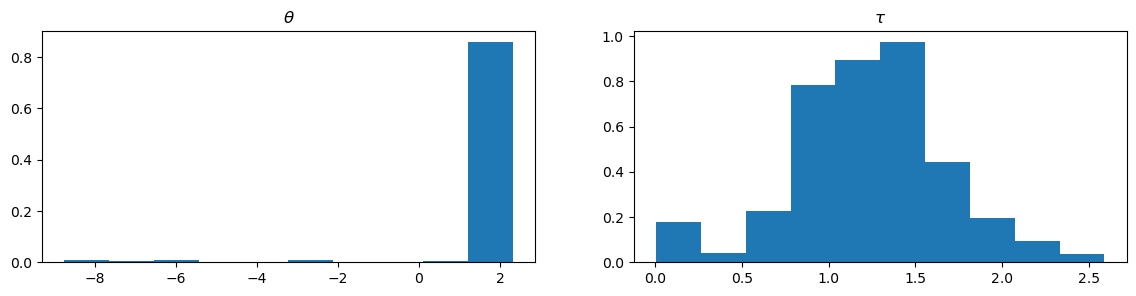

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 3))
ax[0].set_title(r"$\theta$")
ax[1].set_title(r"$\tau$")

ax[0].hist(theta_chain[burn_in:demo_2], density=True)
ax[1].hist(tau_chain[burn_in:demo_2], density=True)

A traditional *Gibbs sampler* updates each parameter by drawing directly from its **full conditional distribution**, \\(p(\theta_j \mid \theta_{\neg j}, x)\\). This is often straightforward in **conjugate** Bayesian models (for example, Gaussian data with Gaussian priors, where posterior distributions also remain Gaussian). However, **in many practical settings**, especially those involving non‐conjugate priors or more complex likelihoods, it may be either *impossible* or *algebraically tedious* to derive a closed‐form expression for each full conditional.  

### When Full Conditionals **Are** Helpful

1. **Conjugacy and Simplicity.**  
   If each parameter’s posterior conditional distribution belongs to a known family (e.g., Gamma, Normal, Beta, etc.), then sampling from the exact conditional is typically fast, numerically stable, and easy to implement.  

2. **Reduced Random-Walk Behavior.**  
   Drawing from exact full conditionals usually leads to more efficient exploration of the parameter space, since each update is drawn **exactly** from its posterior conditional rather than from a rough approximation or proposal that might be rejected.

### When Full Conditionals **Aren’t** Necessary

1. **Non‐Conjugate Priors or Likelihoods.**  
   If the model is complicated enough that \\(p(\theta_j \mid \theta_{\neg j}, x)\\) **cannot** be expressed in a familiar closed form, direct Gibbs sampling is not straightforward. One then must rely on more general methods—like *Metropolis–Hastings* steps—to update each parameter, still operating within a “Gibbs‐like” loop.

2. **Metropolis–within–Gibbs.**  
   In this approach, we never require the **normalizing constant** for the full conditional. Instead, we only need the product  
   \\[
     \underbrace{p(x \mid \theta)}_{\text{likelihood}}
       \times
     \underbrace{p(\theta)}_{\text{prior}}
       \quad\text{(up to a constant)},
   \\]
   and the Metropolis–Hastings acceptance ratio cancels out any unknown constants. Consequently, **as long as we can evaluate** the (unnormalized) probability of one parameter setting relative to another, we can validly perform MCMC updates *without* ever solving for a closed‐form conditional density.

3. **Greater Flexibility.**  
   You are free to use *any* prior (even highly non‐standard) or *any* likelihood, because Metropolis–Hastings does not demand closed‐form integrals. This generality opens the door for a broad range of Bayesian models that are not conjugate.

### Practical Implications

- If **closed‐form** conditionals **exist**, you might use standard Gibbs sampling for simplicity and efficiency.  
- If they **do not** exist (non‐conjugate models, complicated priors, etc.), *Metropolis–Hastings* or *slice sampling* (etc.) can be used to update each parameter in turn, achieving a “Gibbs‐like” framework **without** explicit full‐conditional formulas.  

In short, **deriving full conditional distributions** is *unnecessary* for MCMC as long as you can evaluate the **joint density** for different parameter values. This frees you to handle a wide range of models without wrestling with tricky integrals or custom‐built sampling algorithms.

### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

> For example 
>
> $\begin{align}
\Pr(s_1 \rightarrow s_1) &={}
q(\tilde x^{(t)}=1 | x^{(t-1)}=1) + q(\tilde x^{(t)}=0 | x^{(t-1)}=1) \left(1- \frac{p(\tilde x^{(t)}=0)}{p(x^{(t-1)}=1)}\right)\\
&={} 1/2 + (1/2)(1-(1/3)/(2/3)) = 0.75
\end{align}$

This **transition kernel** $K$ means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 

---

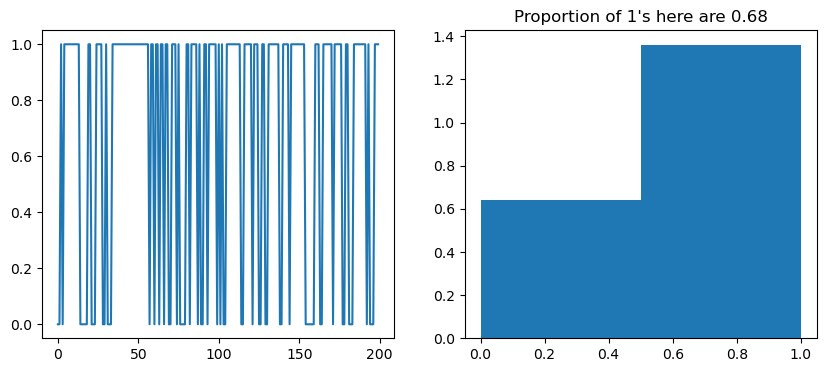

In [11]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

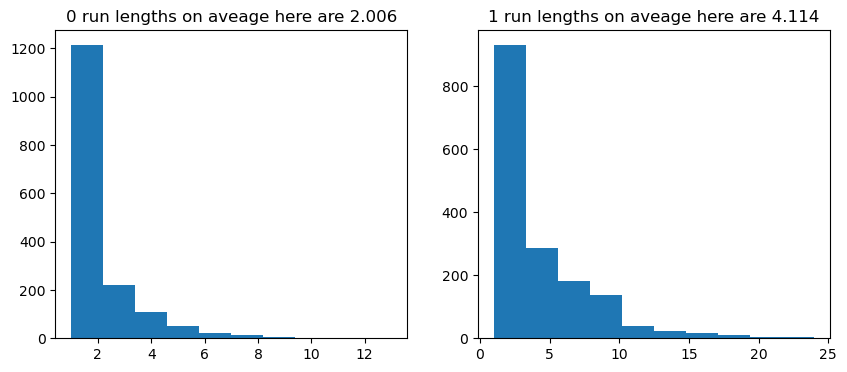

In [12]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));


We wish to target the stationary distribution

\\[
p(x) =
\begin{cases}
\frac{1}{3}, & x = 0,\\[1mm]
\frac{2}{3}, & x = 1,
\end{cases}
\\]

using a Metropolis–Hastings algorithm with proposal distribution

\\[
q(\tilde x \mid x) = \left(\frac{1}{2}\right)^{1-\tilde x} \left(\frac{1}{2}\right)^{\tilde x}.
\\]

This means that regardless of the current state \(x\), the proposal probabilities are

\\[
\Pr(\tilde x = 0 \mid x) = \frac{1}{2} \quad \text{and} \quad \Pr(\tilde x = 1 \mid x) = \frac{1}{2}.
\\]

Recall that the general Metropolis–Hastings acceptance probability is given by

\\[
\alpha(x, \tilde{x}) = \min\Biggl\{1,\, \frac{p(\tilde{x})\,q(x \mid \tilde{x})}{p(x)\,q(\tilde{x} \mid x)}\Biggr\}.
\\]

Since our proposal is symmetric (i.e. \\(q(\tilde{x} \mid x) = q(x \mid \tilde{x}) = \frac{1}{2}\\)), the proposal terms cancel:

\\[
\frac{q(x \mid \tilde{x})}{q(\tilde{x} \mid x)} = 1,
\\]

and so

\\[
\alpha(x, \tilde{x}) = \min\left\{1, \frac{p(\tilde{x})}{p(x)}\right\}.
\\]

Let's now consider the two cases separately.

---

## **Case 1: Current State \\(x=0\\)**

- **Proposal:**  
  \\[
  q(0 \mid 0) = \frac{1}{2}, \quad q(1 \mid 0) = \frac{1}{2}.
  \\]

- **If the candidate is \\(0\\):**  
  Since the proposal \\(\tilde x = 0\\) is identical to the current state, it is automatically accepted. Thus, the probability of moving from 0 to 0 due to this proposal is
  \\[
  \Pr(0 \to 0 \mid \tilde x = 0) = \frac{1}{2}.
  \\]

- **If the candidate is \\(1\\):**  
  The acceptance probability is

  \\[
  \alpha(0,1) = \min\left\{1, \frac{p(1)}{p(0)}\right\} 
  = \min\left\{1, \frac{\frac{2}{3}}{\frac{1}{3}}\right\} 
  = \min\{1, 2\} 
  = 1.
  \\]

  Hence, the probability of moving from 0 to 1 is

  \\[
  \Pr(0 \to 1) = q(1 \mid 0) \cdot \alpha(0,1) = \frac{1}{2} \cdot 1 = \frac{1}{2}.
  \\]

So, for \\(x=0\\):

- \\(\Pr(0 \to 0) = 0.5\\),
- \\(\Pr(0 \to 1) = 0.5\\).

---

## **Case 2: Current State \\(x=1\\)**

- **Proposal:**  
  \\[
  q(0 \mid 1) = \frac{1}{2}, \quad q(1 \mid 1) = \frac{1}{2}.
  \\]

- **If the candidate is \\(1\\):**  
  Since \\(\tilde{x} = 1\\) equals the current state, the proposal is automatically accepted:

  \\[
  \Pr(1 \to 1 \mid \tilde x = 1) = \frac{1}{2}.
  \\]

- **If the candidate is \\(0\\):**  
  The acceptance probability is

  \\[
  \alpha(1,0) = \min\left\{1, \frac{p(0)}{p(1)}\right\} 
  = \min\left\{1, \frac{\frac{1}{3}}{\frac{2}{3}}\right\} 
  = \min\left\{1, \frac{1}{2}\right\} 
  = \frac{1}{2}.
  \\]

  Therefore, the probability of moving from 1 to 0 is

  \\[
  \Pr(1 \to 0) = q(0 \mid 1) \cdot \alpha(1,0) = \frac{1}{2} \cdot \frac{1}{2} = \frac{1}{4}.
  \\]

  Additionally, if the proposal \\(\tilde{x}=0\\) is **rejected** (which occurs with probability \\(1-\alpha(1,0)=\frac{1}{2}\\)), the chain stays at 1. This contributes

  \\[
  q(0 \mid 1) \cdot \Bigl(1 - \alpha(1,0)\Bigr) = \frac{1}{2} \cdot \frac{1}{2} = \frac{1}{4}
  \\]

  to staying in state 1.

Thus, for \\(x=1\\):

- The total probability of staying in state 1 is

  \\[
  \Pr(1 \to 1) = q(1 \mid 1) + q(0 \mid 1)(1 - \alpha(1,0)) = \frac{1}{2} + \frac{1}{4} = \frac{3}{4},
  \\]

- and \\(\Pr(1 \to 0) = \frac{1}{4}\\).

---

## **The Transition Kernel**

Let the transition kernel \\(K\\) be defined as

\\[
K = \begin{bmatrix}
\Pr(x^{(t)}=0 \to x^{(t+1)}=0) & \Pr(x^{(t)}=1 \to x^{(t+1)}=0) \\[1mm]
\Pr(x^{(t)}=0 \to x^{(t+1)}=1) & \Pr(x^{(t)}=1 \to x^{(t+1)}=1)
\end{bmatrix}.
\\]

From our derivation, we have

\\[
K = \begin{bmatrix}
0.5 & 0.25 \\
0.5 & 0.75
\end{bmatrix}.
\\]

This kernel means that:

- If the current state is **0**:
  - There is a 50% chance to remain at 0.
  - There is a 50% chance to switch to 1.
- If the current state is **1**:
  - There is a 25% chance to switch to 0.
  - There is a 75% chance to remain at 1.

The geometric waiting times (i.e., the expected number of iterations before switching) are then:
- For state 0: \\(E(\text{waiting time}) = \frac{1}{0.5} = 2\\) iterations.
- For state 1: \\(E(\text{waiting time}) = \frac{1}{0.25} = 4\\) iterations.

These run lengths yield the overall stationary ratio of 1/3 for 0’s and 2/3 for 1’s.
